# ADMT Demo API

Katie Mills & Donata Giglio, Department of Atmospheric and Oceanic Sciences at University of Colorado Boulder

## Introduction

The Argovis team at the University of Colorado has produced a demonstration API based on their work on [argovis.colorado.edu](https://argovis.colorado.edu), reimplemented to support the Argo collaboration's goals of providing rapid access to Argo data from the cloud, university datacenters, or individual scientists' and students' machines. Our specific goals for this demo are:

 - Make the entire Argo dataset to date searchable by arbitrary geographic region, timespan, and data included, and make results filterable by depth and QC flag per level.
 - Deliver results as rapidly as possible, enabling live consumption of Argo data in things like interactive web apps and jupyter notebooks.
 - Provide an extensible implementation of the above that can be modified to suit the needs and requests of the ADMT(as an example, this demo can be readily modified to include the option to filter by data mode and/or other metadata).

This demo differs from our existing work at [argovis.colorado.edu](https://argovis.colorado.edu) in the following ways:
  
  - This work represents Argo profiles as literally as possible, matching the existing netCDF nomenclature closely, in order to present an example of what a consumer-agnostic JSON representation of Argo data could look like.
  - This work includes all Argo profiles, including Argo B-files, and including all profiles in the upstream netCDF files.

We are delivering and operating this demo as a proof of principle only, which means:

 - It will only be live until **November 30, 2024** at the latest, lacking additional support.
 - Implementation is in draft form, please expect and report bugs to argovis@colorado.edu.
 - Feature set (what you can search and filter by) is currently a minimum viable product, but can be expanded to include any search, filter, or transform features the ADMT likes.

## Architecture

This demo is architected as a simple two-component database and API:

 - MongoDB 7.0.8
 - a custom REST API written in Rust to provide search and filtering capabilities.

In addition to the database and API, a containerized update process runs every night to sync new profiles posted by IFREMER. All these components are containerized and orchestrated with Docker Swarm; as such, all tooling is either open source (in the case of all custom components, see code [here](https://github.com/bkatiemills/admt-demo-api)) or free to use (in the case of MongoDB and Docker), and therefore incur no operational costs.

This demo is currently deployed to a single t2.large virtual server on AWS' EC2, running Ubuntu with a 700 GB EBS storage backing. Therefore:

 - estimated monthly infrastructure cost is $139 USD plus data egress costs (0.09/GB)
 - because this doesn't leverage any special AWS services, it could easily be migrated to other clouds or institutional datacenters.

## Accessing data

### Simple map

This demo provides a REST API over the entire Argo dataset. Let's start by mapping all the profiles collected in the first week of 2024; note at least for this demo, we use Argo's raw JULD value for dates (a more natural date syntax can be easily implemented in a production version of this API):

In [1]:
import requests, copy, pandas, json
import matplotlib.pyplot as plt
import Exploring_Argo_BGC_with_Argovis_helpers as helpers
import warnings
warnings.filterwarnings('ignore')

API_PREFIX = 'http://54.82.5.112:8080/search'

jan1_2024 = 27028 # days since jan 1 1950, the Argo epoch

query_parameters = {
    "startDate": jan1_2024,
    "endDate": jan1_2024+7,
    "mode": "map"       # use the "map" mode to download just enough data to create a map
} 

# this API is paginated. To get all the results you expect, keep asking for pages until you get an empty response.
def exhaust_pages(query_string_parameters, api=API_PREFIX):
    q = copy.deepcopy(query_string_parameters)
    q['page'] = 0
    docs = []
    res = requests.get(api, params = q).json()
    docs += res
    while len(res) > 0:
        q['page'] += 1
        res = requests.get(api, params = q).json()
        docs += res
    return docs

In [2]:
map_data = exhaust_pages(query_parameters)

In [3]:
# map mode data has just an id, geolocation, JULD, and the IFREMER file it all came from.
print(map_data[0])

{'_id': 'R3901857_270_0', 'geolocation': {'type': 'Point', 'coordinates': [-39.327513333333336, 18.80339]}, 'JULD': 27034.99826388889, 'STATION_PARAMETERS': ['MTIME', 'PRES', 'TEMP', 'PSAL'], 'source_file': 'ftp://ftp.ifremer.fr/ifremer/argo/dac/coriolis/3901857/profiles/R3901857_270.nc'}


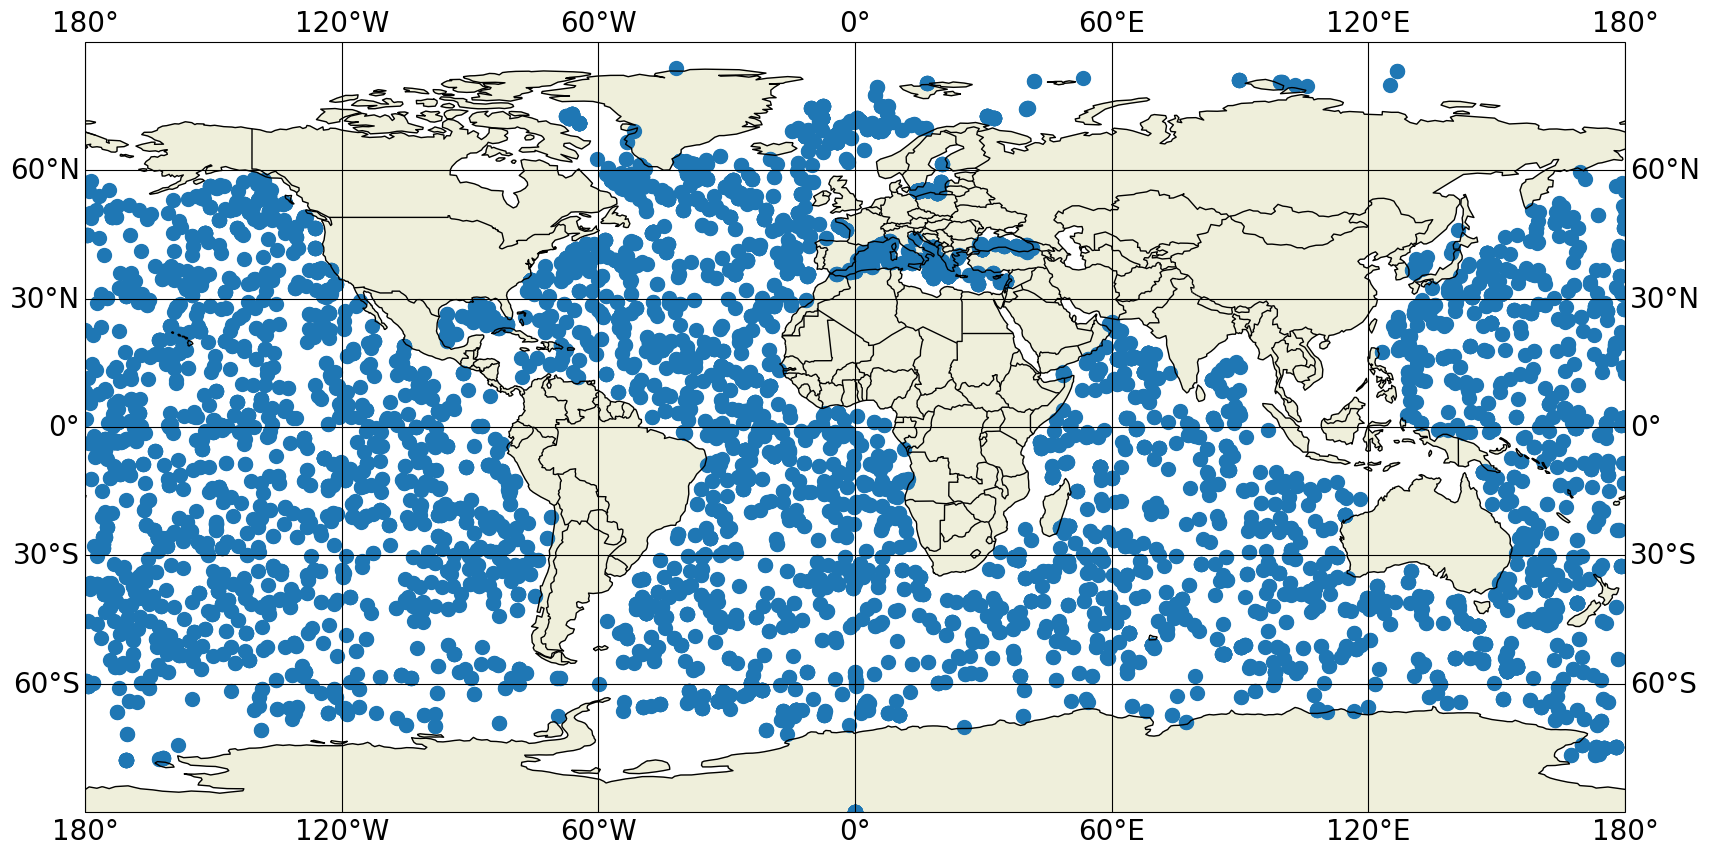

In [4]:
longitudes = [x['geolocation']['coordinates'][0] for x in map_data]
latitudes = [x['geolocation']['coordinates'][1] for x in map_data]

helpers.simple_map(longitudes, latitudes)

Or, we could ask the API to filter by data available; let's ask for only profiles that have dissolved oxygen, pressure, and temperature avaialble or 'DOXY', 'PRES' and 'TEMP' in Argo parlance:

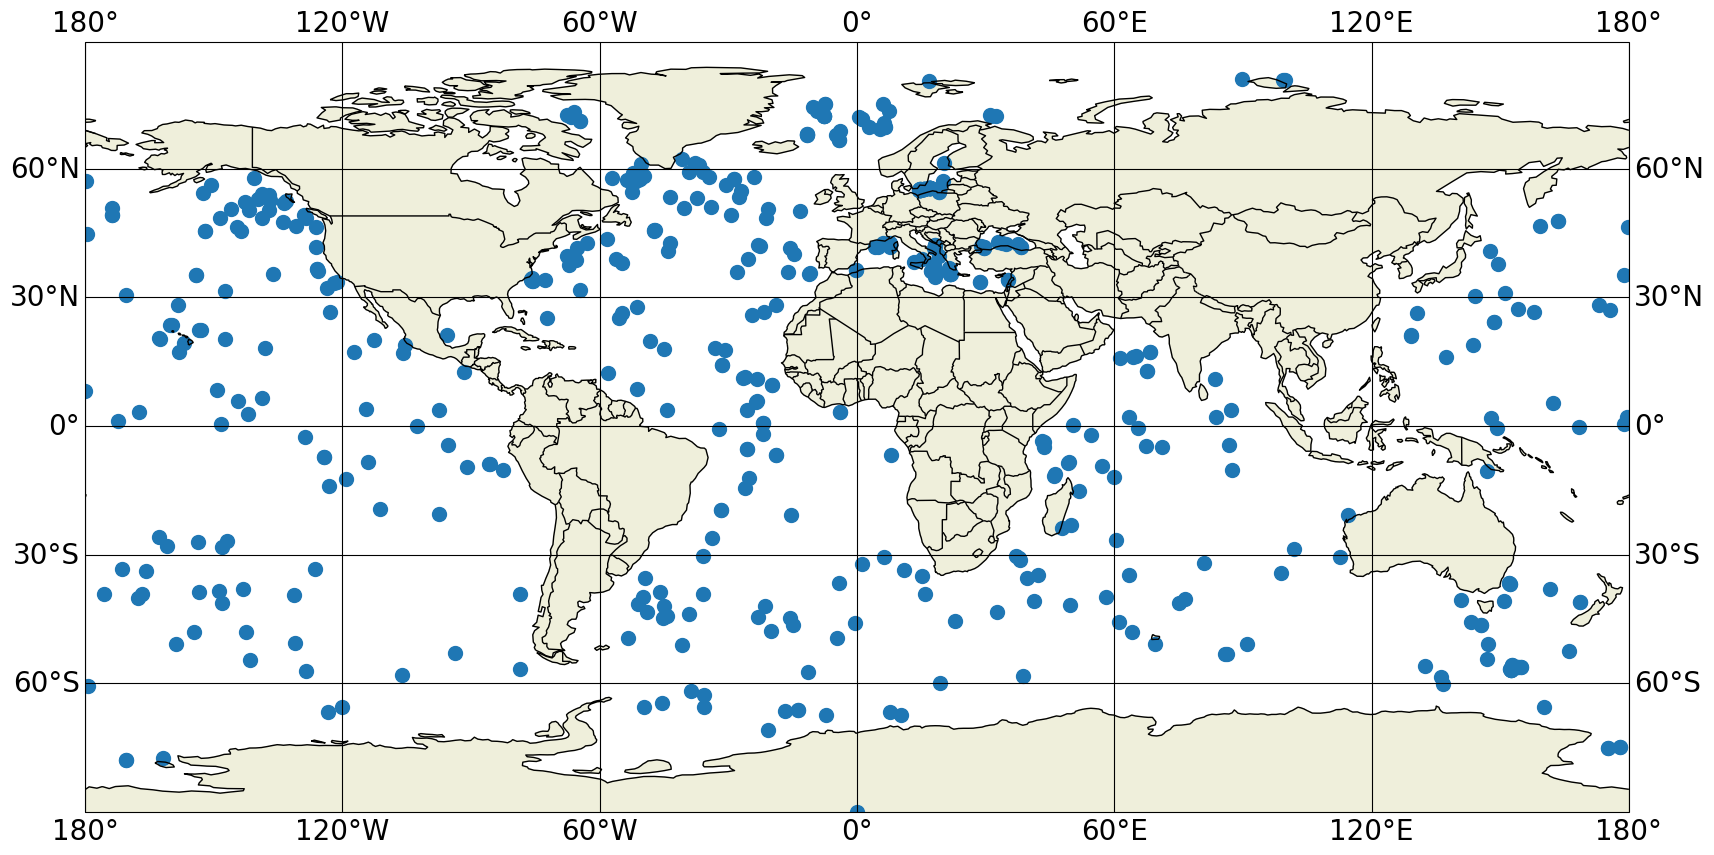

In [5]:
query_parameters = {
    "startDate": jan1_2024,
    "endDate": jan1_2024+7,
    "mode": "map",
    "data": 'DOXY,PRES,TEMP',
} 
map_data = exhaust_pages(query_parameters)

longitudes = [x['geolocation']['coordinates'][0] for x in map_data]
latitudes = [x['geolocation']['coordinates'][1] for x in map_data]
helpers.simple_map(longitudes, latitudes)

### Accessing profile data

We can get full profile data for these points in much the same way, just by omitting the 'map' mode. Let's also confine our attention to the top 100 dbar of the profiles, and only keep levels with QC 1 for dissolved oxygen:

In [6]:
query_parameters = {
    "startDate": jan1_2024,
    "endDate": jan1_2024+7,
    "data": 'DOXY,1,PRES,TEMP',  # download doxy, pres and temp, but only keep levels that have doxy QC==1.
    "presRange": '0,100'         # only keep levels from 0 to 100 dbar
} 

profile_data = exhaust_pages(query_parameters)

We'll use the adjusted data here for example as we turn this into a more familiar data frame:

In [7]:
def create_dataframe(data_list, variables):
    data = []

    for item in data_list:
        adjusted_data = item.get('adjusted_data', {})
        var_lists = [adjusted_data.get(var, []) for var in variables]
        juld = item.get('JULD')
        point = item.get('geolocation', {})
        longitude = point.get('coordinates', [None, None])[0]
        latitude = point.get('coordinates', [None, None])[1]

        for values in zip(*var_lists):
            data.append(list(values) + [juld, longitude, latitude])

    df = pandas.DataFrame(data, columns=variables + ['JULD', 'longitude', 'latitude'])

    return df

In [8]:
df = create_dataframe(profile_data, ['DOXY', 'TEMP', 'PRES'])

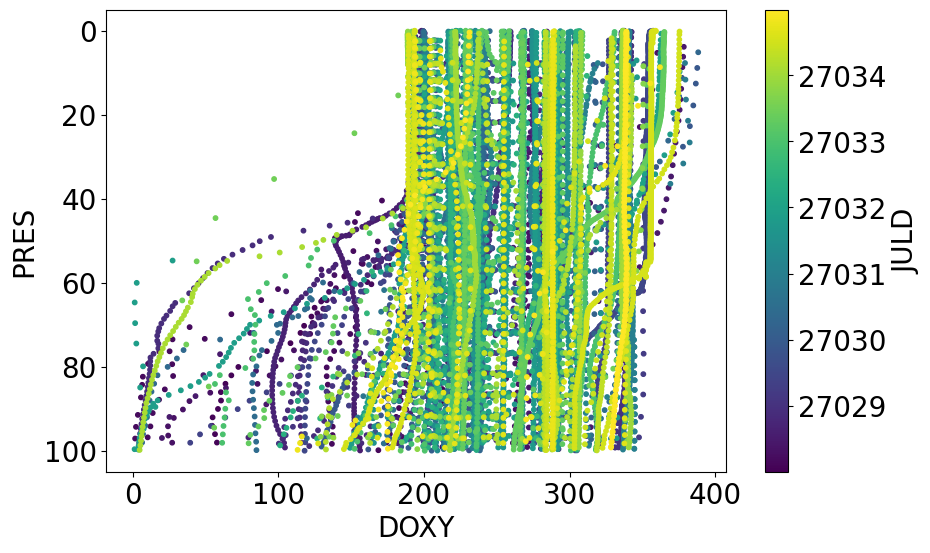

In [9]:
def plot_dataframe(df, x_col, y_col, color_col, reverse_y):
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(df[x_col], df[y_col], c=df[color_col], cmap='viridis', s=10)
    if reverse_y:
        plt.gca().invert_yaxis()  # Reverse the y-axis
    plt.colorbar(sc, label=color_col)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

plot_dataframe(df, 'DOXY', 'PRES', 'JULD', True)

This is pretty busy - our API also lets us narrow down our query geographically, in arbitrary polygon shaped regions defined as a list of [longitude, latitude] pairs; let's map the profiles this matches, and then plot the corresponding dissolved oxygen profiles:

In [10]:
# a polygon in [lon, lat] pairs encompassing the eastern North Pacific;
# notice the first and last vertex must match per the geojson spec
# vertexes will be joined by geodesics to form search region
enp = [[[-154.46368957465623,60.76947380324188],[-176.7426834172754,51.724050773956805],[-160.3931801125427,35.60010796537833],[-124.06958924590836,37.51560890505726],[-117.87265044213612,49.61105911411957],[-133.4978638889061,63.18887615609711],[-154.46368957465623,60.76947380324188]]]
query_parameters = {
    "startDate": 27028,
    "endDate": 27035,
    "data": 'DOXY,1,PRES,TEMP',
    "presRange": '0,100',
    "polygon": json.dumps(enp)
} 
profile_data = exhaust_pages(query_parameters)

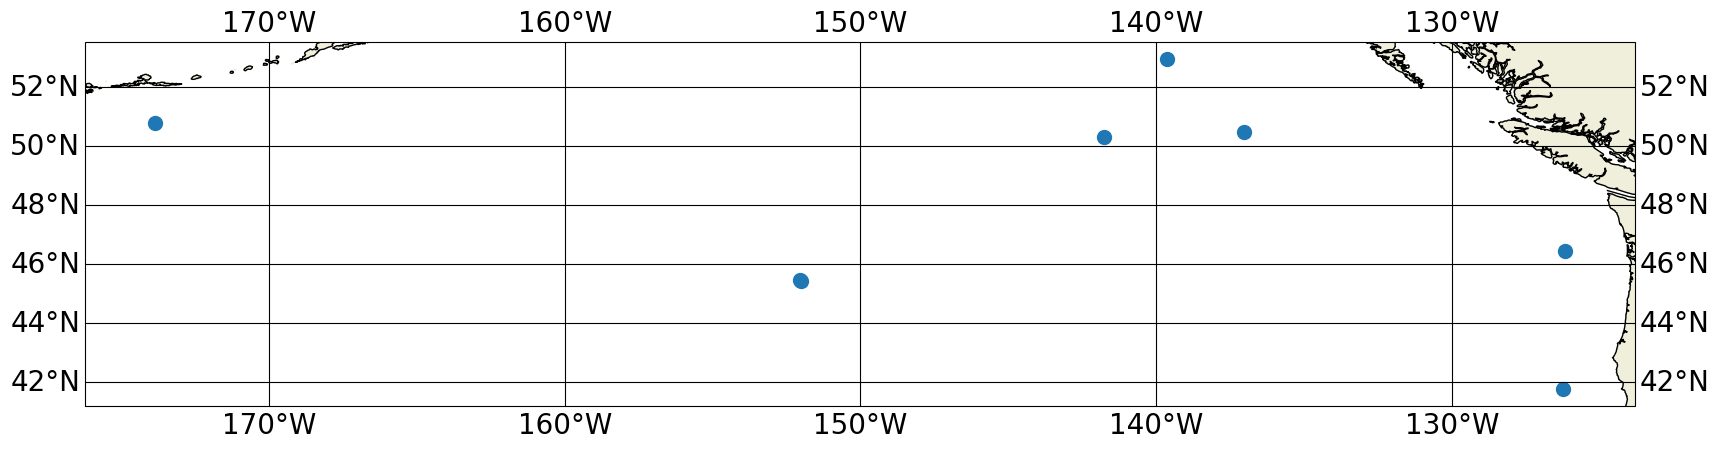

In [11]:
longitudes = [x['geolocation']['coordinates'][0] for x in profile_data]
latitudes = [x['geolocation']['coordinates'][1] for x in profile_data]

helpers.simple_map(longitudes, latitudes)

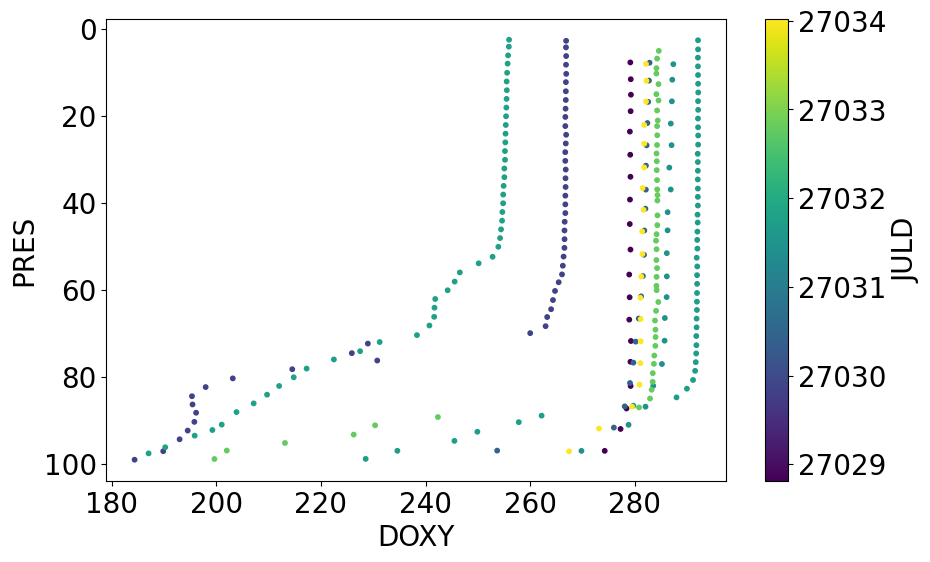

In [12]:
df = create_dataframe(profile_data, ['DOXY', 'TEMP', 'PRES'])
plot_dataframe(df, 'DOXY', 'PRES', 'JULD', True)

## Appendix: latency benchmarking

The examples above illustrate just some of the functionality we can offer users with a fully-featured API. Besides feature set, we're also interested in speed; being able to interrogate the Argo dataset in real time allows us to explore questions and ideas without hours or even days of download latency interrupting the process.

In order to benchmark our API, we do some very simple serial latency tests with Apache Bench. Most salient numbers below are the maximum time needed to make a request (since this reflects the time needed to pull randomly-accessed data off of disk from a standing start), and the median request time (the difference between which and the maximum time giving some indication of the upper limit on possible speedup available with enough resources to hold the entire database in memory, rather than having to fetch from disk).

### Cloud -> local computer performance

Let's begin by asking for complete profiles in a 10 degree box in the Pacific over a one year span, issuing requests from my home internet connection; bear in mind that as discussed, this API is paginated, so these requests represent the first page of results (up to 1000 profiles):

```
~/admt/api ( main)$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-140,0],[-140,-10],[-130,-10],[-130,0],[-140,0]]]&startDate=23000&endDate=23365"
This is ApacheBench, Version 2.3 <$Revision: 1903618 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-140,0],[-140,-10],[-130,-10],[-130,0],[-140,0]]]&startDate=23000&endDate=23365
Document Length:        28205405 bytes

Concurrency Level:      1
Time taken for tests:   17.910 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      282055190 bytes
HTML transferred:       282054050 bytes
Requests per second:    0.56 [#/sec] (mean)
Time per request:       1790.973 [ms] (mean)
Time per request:       1790.973 [ms] (mean, across all concurrent requests)
Transfer rate:          15379.60 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       13   29  24.5     18      86
Processing:  1321 1762 961.2   1396    4460
Waiting:      536  636 166.1    591    1092
Total:       1349 1791 958.2   1438    4476

Percentage of the requests served within a certain time (ms)
  50%   1438
  66%   1481
  75%   1629
  80%   1916
  90%   4476
  95%   4476
  98%   4476
  99%   4476
 100%   4476 (longest request)
```

So our worst case latency was 4.476 seconds for this download, that corresponds to 450 profiles or about 28 MB of profile data. The main contributors to this time are disk and network latency: the amount of time it takes to pull this data off of disk, and the amount of time it takes to push it over the wire to my laptop at home. We can get an idea of the relative scale of these two factors by comparing this to the median request time, which was 1.438 seconds: presumably this data was cached in memory by the database after it was accessed the first time, making immediately following accesses much faster, leaving mostly only the network transfer time.

What if we focus our attention to a more targeted search? Perhaps the matter at hand only really requires pressure and temeprature data; let's benchmark a similar request that only transmits the level data for these two measurements (note we pick a slightly different region so we aren't just requesting cached data):

```
~/admt/api ( main)$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-160,0],[-160,-10],[-150,-10],[-150,0],[-160,0]]]&startDate=23000&endDate=23365&data=TEMP,PRES"
This is ApacheBench, Version 2.3 <$Revision: 1903618 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-160,0],[-160,-10],[-150,-10],[-150,0],[-160,0]]]&startDate=23000&endDate=23365&data=TEMP,PRES
Document Length:        17415726 bytes

Concurrency Level:      1
Time taken for tests:   11.042 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      174158400 bytes
HTML transferred:       174157260 bytes
Requests per second:    0.91 [#/sec] (mean)
Time per request:       1104.220 [ms] (mean)
Time per request:       1104.220 [ms] (mean, across all concurrent requests)
Transfer rate:          15402.42 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       12   28  37.5     17     135
Processing:   894 1076 212.6   1015    1484
Waiting:      376  464 139.7    414     847
Total:        911 1104 237.3   1033    1576

Percentage of the requests served within a certain time (ms)
  50%   1033
  66%   1068
  75%   1093
  80%   1502
  90%   1576
  95%   1576
  98%   1576
  99%   1576
 100%   1576 (longest request)
```

So we're down to 1.6 s at worst when focusing on a couple variables of interest; if we're only interested in a range of levels, such as for example the top 100 dbar of the ocean, we do even better still:

```
~/admt/api ( main)$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-170,0],[-170,-10],[-160,-10],[-160,0],[-170,0]]]&startDate=23000&endDate=23365&data=TEMP,PRES&presRange=0,100"
This is ApacheBench, Version 2.3 <$Revision: 1903618 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-170,0],[-170,-10],[-160,-10],[-160,0],[-170,0]]]&startDate=23000&endDate=23365&data=TEMP,PRES&presRange=0,100
Document Length:        1686079 bytes

Concurrency Level:      1
Time taken for tests:   4.493 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      16861920 bytes
HTML transferred:       16860790 bytes
Requests per second:    2.23 [#/sec] (mean)
Time per request:       449.341 [ms] (mean)
Time per request:       449.341 [ms] (mean, across all concurrent requests)
Transfer rate:          3664.63 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       12   18   3.9     18      24
Processing:   347  431 226.4    354    1073
Waiting:      202  277 223.4    208     913
Total:        367  449 228.4    371    1097

Percentage of the requests served within a certain time (ms)
  50%    371
  66%    374
  75%    376
  80%    433
  90%   1097
  95%   1097
  98%   1097
  99%   1097
 100%   1097 (longest request)
```

We're down to about a second, and potentially at the hundreds of milliseconds range in an environment with enough memory to cache the whole database. As a final example, let’s only request the information to create a map showing locations for profiles of interest:

```
~/admt/api ( main)$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-130,0],[-130,-10],[-120,-10],[-120,0],[-130,0]]]&startDate=23000&endDate=23365&mode=map"
This is ApacheBench, Version 2.3 <$Revision: 1903618 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-130,0],[-130,-10],[-120,-10],[-120,0],[-130,0]]]&startDate=23000&endDate=23365&mode=map
Document Length:        143277 bytes

Concurrency Level:      1
Time taken for tests:   1.356 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      1433890 bytes
HTML transferred:       1432770 bytes
Requests per second:    7.38 [#/sec] (mean)
Time per request:       135.590 [ms] (mean)
Time per request:       135.590 [ms] (mean, across all concurrent requests)
Transfer rate:          1032.74 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       15   18   1.4     18      20
Processing:   108  118  13.0    113     150
Waiting:       54   59  12.0     55      93
Total:        126  135  12.2    131     164

Percentage of the requests served within a certain time (ms)
  50%    131
  66%    135
  75%    140
  80%    147
  90%    164
  95%    164
  98%    164
  99%    164
 100%    164 (longest request)
```

So here we're down to the 100 ms range for mapping-only data (it's worth noting that there's more going on here than simply handling less data; mapping-only requests actually search a database with minimally-sized records, avoiding disk latency with larger documents).

### Cloud only performance

Much of the recent discussion of data distribution strategies at Argo has centered on 'cloud readiness', the main practical upshot of which is the ability to push compute to the cloud where the data lives, rather than having to download it locally. An API driven data service like this one, which requires nothing but an internet connection and is supported by every programming language and environment in the world, can easily take advantage of cloud computing advantages; let's do some similar benchmarking as above, but this time from AWS, colocated in the datacener serving this data.

First let's perform a similar request to the first, asking for the first page of all the data in a 10 degree box in the mid Atlantic:

```
ubuntu@ip-10-0-0-11:~$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-60,20],[-60,10],[-50,10],[-50,20],[-60,20]]]&startDate=23000&endDate=23365"
This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-60,20],[-60,10],[-50,10],[-50,20],[-60,20]]]&startDate=23000&endDate=23365
Document Length:        53319117 bytes

Concurrency Level:      1
Time taken for tests:   16.765 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      533192310 bytes
HTML transferred:       533191170 bytes
Requests per second:    0.60 [#/sec] (mean)
Time per request:       1676.490 [ms] (mean)
Time per request:       1676.490 [ms] (mean, across all concurrent requests)
Transfer rate:          31058.67 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:        0    1   0.2      1       1
Processing:  1554 1676 274.7   1589    2452
Waiting:     1105 1202 279.3   1112    1996
Total:       1554 1676 274.8   1589    2453

Percentage of the requests served within a certain time (ms)
  50%   1589
  66%   1593
  75%   1608
  80%   1666
  90%   2453
  95%   2453
  98%   2453
  99%   2453
 100%   2453 (longest request)
```

Note the data volume in comparison: we hit a relatively data-rich region here and got results that are about twice the size of the corresponding test in the Pacific - neverthelss in half the time. Let's follow the same progression as we did above, narrowing down to just pressure and temperature:

```
ubuntu@ip-10-0-0-11:~$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-50,20],[-50,10],[-40,10],[-40,20],[-50,20]]]&startDate=23000&endDate=23365&data=PRES,TEMP"
This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-50,20],[-50,10],[-40,10],[-40,20],[-50,20]]]&startDate=23000&endDate=23365&data=PRES,TEMP
Document Length:        21869728 bytes

Concurrency Level:      1
Time taken for tests:   7.171 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      218698420 bytes
HTML transferred:       218697280 bytes
Requests per second:    1.39 [#/sec] (mean)
Time per request:       717.130 [ms] (mean)
Time per request:       717.130 [ms] (mean, across all concurrent requests)
Transfer rate:          29781.60 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:        0    1   2.3      1       8
Processing:   634  716 190.1    652    1254
Waiting:      450  520 194.6    457    1074
Total:        635  717 190.0    654    1255

Percentage of the requests served within a certain time (ms)
  50%    654
  66%    655
  75%    679
  80%    701
  90%   1255
  95%   1255
  98%   1255
  99%   1255
 100%   1255 (longest request)
```

similarly faster despite larger download size compared to the Pacific data download to local network we started with. Let's again zoom into the top 100 dbar:

```
ubuntu@ip-10-0-0-11:~$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-40,20],[-40,10],[-30,10],[-30,20],[-40,20]]]&startDate=23000&endDate=23365&data=PRES,TEMP&presRange=0,100"
This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-40,20],[-40,10],[-30,10],[-30,20],[-40,20]]]&startDate=23000&endDate=23365&data=PRES,TEMP&presRange=0,100
Document Length:        4334696 bytes

Concurrency Level:      1
Time taken for tests:   2.803 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      43348090 bytes
HTML transferred:       43346960 bytes
Requests per second:    3.57 [#/sec] (mean)
Time per request:       280.323 [ms] (mean)
Time per request:       280.323 [ms] (mean, across all concurrent requests)
Transfer rate:          15101.19 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:        0    1   0.2      1       1
Processing:   268  280  26.9    271     356
Waiting:      230  241  27.8    232     320
Total:        268  280  27.0    271     357

Percentage of the requests served within a certain time (ms)
  50%    271
  66%    274
  75%    275
  80%    278
  90%    357
  95%    357
  98%    357
  99%    357
 100%    357 (longest request)
```

Less than 400 ms in the worst case. Finally, a nearby mapping call:

```
ubuntu@ip-10-0-0-11:~$ ab -n 10 -c 1 "http://54.82.5.112:8080/search?polygon=[[[-30,20],[-30,10],[-20,10],[-20,20],[-30,20]]]&startDate=23000&endDate=23365&mode=map"
This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking 54.82.5.112 (be patient).....done


Server Software:        
Server Hostname:        54.82.5.112
Server Port:            8080

Document Path:          /search?polygon=[[[-30,20],[-30,10],[-20,10],[-20,20],[-30,20]]]&startDate=23000&endDate=23365&mode=map
Document Length:        134357 bytes

Concurrency Level:      1
Time taken for tests:   0.438 seconds
Complete requests:      10
Failed requests:        0
Total transferred:      1344690 bytes
HTML transferred:       1343570 bytes
Requests per second:    22.81 [#/sec] (mean)
Time per request:       43.835 [ms] (mean)
Time per request:       43.835 [ms] (mean, across all concurrent requests)
Transfer rate:          2995.72 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:        0    1   0.3      1       1
Processing:    39   43   7.0     41      62
Waiting:       37   40   6.9     37      59
Total:         40   44   7.3     41      64

Percentage of the requests served within a certain time (ms)
  50%     41
  66%     42
  75%     43
  80%     46
  90%     64
  95%     64
  98%     64
  99%     64
 100%     64 (longest request)
```

We demonstrate order-of-magnitude 10 ms response times for mapping requests in-cloud.

## Conclusion

API and database driven services underwrite the modern Internet in all sectors, thanks to their flexibility and performance. The demo API that we have built is only a first pass at illustrating what this technology can do for the Argo program; it's worth noting that this was accomplished by a single engineer with a minimal time investment, leading us to anticipate additional perfomance gains and richer functionality still, if a serious effort is put behind this approach. Directions for future work that immediately come to mind include implementing even more precise data targeting (delayed versus realtime, or BGC versus core, for example), as well as exploring read latency mitigation via approaches like caching large parts of the database, reading it from disks colocated (rather than network-mounted) with the API sever, and read parallelization via a sharded database structure.